<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Check GPU**

In [1]:
!!nvidia-smi

['Thu Jan 14 14:45:48 2021       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|                               |                      |               MIG M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   69C    P0    79W / 149W |      0MiB / 11441MiB |      0%      Default |',
 '|                               |                      |                 ERR! |',
 '+-------------------------------+----------------------+----------------------+',
 '                                      

# **Import Libraries**

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [3]:
tf.compat.v1.disable_eager_execution()

# **Hyperparameters**

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

EPOCHS = 100

BATCH_SIZE = 32

LR = 1e-4

# **Data**

## **Clone Data**

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA

fatal: destination path 'PJ61403_DATA' already exists and is not an empty directory.


In [6]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-25-25

fatal: destination path 'PJ61403_DATA_split_50-25-25' already exists and is not an empty directory.


In [7]:
train_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/train'

val_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val'

test_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test'

## **Data Augmentation**

In [8]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_aug.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode ='categorical')

val_generator = val_aug.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical')

test_generator = test_aug.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 121 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


# **Model**

## **Base Model**

In [10]:
base_model = tf.keras.models.load_model('/content/6_scratch_CW_densenet121_84_model.h5')

In [11]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
num_layers = len(base_model.layers)

## **New Model**

In [13]:
for i in range(num_layers):
    base_model.layers[i].trainable = False

x = base_model.layers[num_layers-2].output
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
prediction = Dense(4, activation='softmax')(x)

new_model = Model(inputs=base_model.input,outputs=prediction)

In [14]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# **Compile**

In [15]:
new_model.compile(optimizer=Adam(LR), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## **Callbacks**

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='/content/pj61043_densenet121_model_cw2.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

# **Training**

In [17]:
history = new_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        callbacks=[early_stop, model_checkpoint, reduce_lr_rate])

Epoch 1/100
4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 30.2500 - loss: 2.1275 - accuracy: 0.1488

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4/4 [==============================] - 65s 19s/step - batch: 1.5000 - size: 30.2500 - loss: 2.1275 - accuracy: 0.1488 - val_loss: 1.7071 - val_accuracy: 0.3000
Epoch 2/100
4/4 [==============================] - 4s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.8436 - accuracy: 0.2810 - val_loss: 1.6759 - val_accuracy: 0.3333
Epoch 3/100
4/4 [==============================] - 5s 2s/step - batch: 1.5000 - size: 30.2500 - loss: 1.7955 - accuracy: 0.1983 - val_loss: 1.6285 - val_accuracy: 0.3667
Epoch 4/100
4/4 [==============================] - 5s 2s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6737 - accuracy: 0.2893 - val_loss: 1.6072 - val_accuracy: 0.4667
Epoch 5/100
4/4 [==============================] - 5s 2s/step - batch: 1.5000 - size: 30.2500 - loss: 1.7577 - accuracy: 0.2479 - val_loss: 1.5905 - val_accuracy: 0.4500
Epoch 6/100
4/4 [==============================] - 5s 2s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6579 - accuracy: 0.2810 - val_loss: 1.5775 - val_accurac

# **Graph**

## **Accuracy**

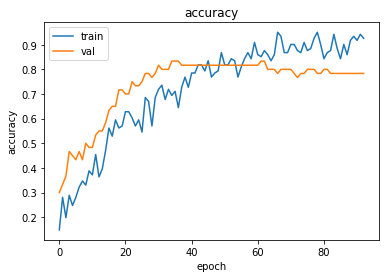

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## **Loss**

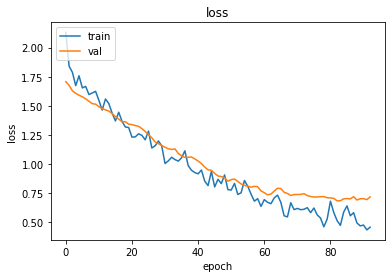

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [20]:
test_model = tf.keras.models.load_model('/content/pj61043_densenet121_model_cw2.h5')

In [21]:
num_test_files = len(test_generator.filenames)

In [22]:
test_generator.reset()

In [23]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## **Confusion Matrix**

Confusion matrix, without normalization
[[12  4  1  0]
 [ 0 15  0  0]
 [ 0  2 13  1]
 [ 0  0  4 11]]


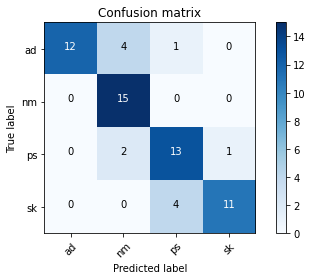

In [24]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

Normalized confusion matrix
[[0.70588235 0.23529412 0.05882353 0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.125      0.8125     0.0625    ]
 [0.         0.         0.26666667 0.73333333]]


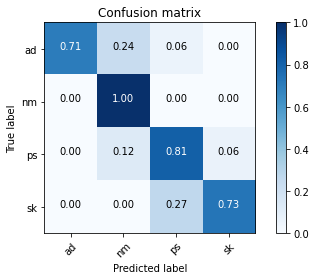

In [25]:
plot_confusion_matrix(cm, classes_names, True)

In [26]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[12  4  1  0]
 [ 0 15  0  0]
 [ 0  2 13  1]
 [ 0  0  4 11]]
Classification Report
              precision    recall  f1-score   support

          ad       1.00      0.71      0.83        17
          nm       0.71      1.00      0.83        15
          ps       0.72      0.81      0.76        16
          sk       0.92      0.73      0.81        15

    accuracy                           0.81        63
   macro avg       0.84      0.81      0.81        63
weighted avg       0.84      0.81      0.81        63



## **Grad-CAM**

In [27]:
last_conv2d = 'conv5_block16_2_conv'

### **AD**

In [28]:
akiec_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ad/ad1.jpg'

Model prediction:
	ad             	(0)	with probability 0.912
	nm             	(1)	with probability 0.049
	ps             	(2)	with probability 0.025
	sk             	(3)	with probability 0.014
Explanation for 'ad'


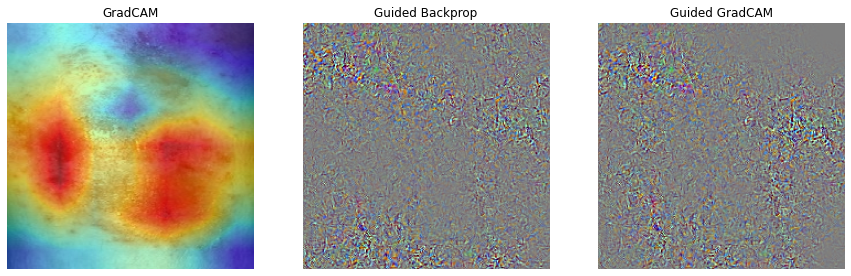

In [29]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### **NM**

In [30]:
nm_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/nm/nm4.jpg'

Model prediction:
	nm             	(1)	with probability 0.936
	sk             	(3)	with probability 0.043
	ps             	(2)	with probability 0.011
	ad             	(0)	with probability 0.010
Explanation for 'nm'


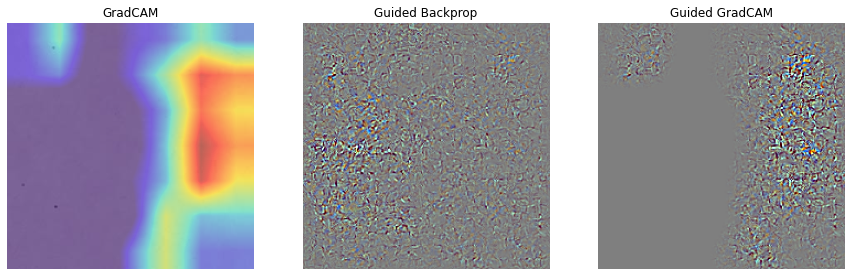

In [31]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, nm_img, layer_name=last_conv2d)

### **PS**

In [32]:
ps_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ps/ps57.jpg'

Model prediction:
	ps             	(2)	with probability 0.876
	nm             	(1)	with probability 0.068
	sk             	(3)	with probability 0.035
	ad             	(0)	with probability 0.021
Explanation for 'ps'


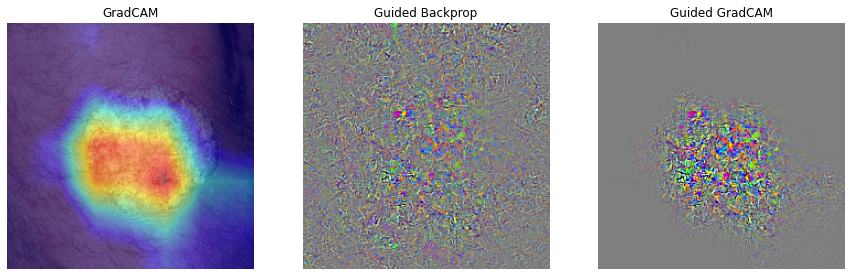

In [33]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ps_img, layer_name=last_conv2d)

### **SK**

In [34]:
sk_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/sk/sk4.jpg'

Model prediction:
	sk             	(3)	with probability 0.953
	nm             	(1)	with probability 0.023
	ps             	(2)	with probability 0.021
	ad             	(0)	with probability 0.004
Explanation for 'sk'


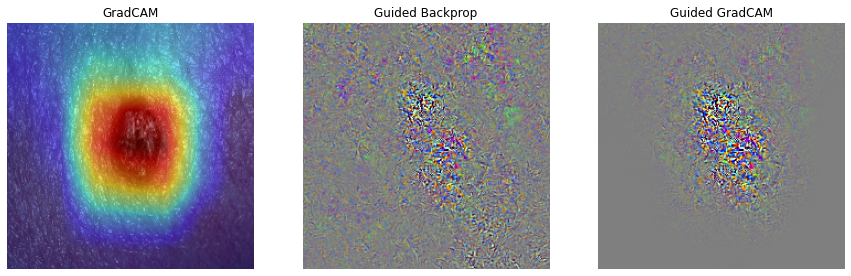

In [35]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, sk_img, layer_name=last_conv2d)